# Assignment - SS8GC

## 1. Creation of context

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import pandas as pd
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import VectorAssembler

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Initialize the spark environment

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

### Read data

In [4]:
dataPath = "db.csv"
df = sqlc.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)

## 2. Preparation of data (get it into parquet)

### Write parquet

In [5]:
parquetPath = '/home/ec2-user/SageMaker/ss8gc/pqt'

In [ ]:
df.write.parquet(parquetPath)

### Write to spark dataframe from parquet

In [6]:
df = sqlc.read.parquet(parquetPath)
display(df)

DataFrame[F1: double, F2: double, F3: double, F4: double, target: int]

In [7]:
df.printSchema()

root
 |-- F1: double (nullable = true)
 |-- F2: double (nullable = true)
 |-- F3: double (nullable = true)
 |-- F4: double (nullable = true)
 |-- target: integer (nullable = true)



In [8]:
df.take(5)

[Row(F1=5.1, F2=3.5, F3=1.4, F4=0.2, target=0),
 Row(F1=4.9, F2=3.0, F3=1.4, F4=0.2, target=0),
 Row(F1=4.7, F2=3.2, F3=1.3, F4=0.2, target=0),
 Row(F1=4.6, F2=3.1, F3=1.5, F4=0.2, target=0),
 Row(F1=5.0, F2=3.6, F3=1.4, F4=0.2, target=0)]

## 3. MLlib based analysis

In [9]:
print("Pearson's r(F1,F2) = {}".format(df.corr("F1", "F2")))
print("Pearson's r(F1,F3) = {}".format(df.corr("F1", "F3")))
print("Pearson's r(F1,F4) = {}".format(df.corr("F1", "F4")))
print("Pearson's r(F1,F3) = {}".format(df.corr("F2", "F3")))
print("Pearson's r(F1,F4) = {}".format(df.corr("F2", "F4")))
print("Pearson's r(F1,F4) = {}".format(df.corr("F3", "F4")))

Pearson's r(F1,F2) = -0.19764562926413792
Pearson's r(F1,F3) = 0.8123892148022642
Pearson's r(F1,F4) = 0.7896132797817184
Pearson's r(F1,F3) = -0.5957609313698715
Pearson's r(F1,F4) = -0.5601196244020626
Pearson's r(F1,F4) = 0.9788556612553715


In [10]:
assembler = VectorAssembler(
    inputCols=['F1','F2','F3','F4'],
    outputCol="features")

df = assembler.transform(df)
print(df)

# rename to make ML engine happy
df = df.withColumnRenamed("target", "label")

DataFrame[F1: double, F2: double, F3: double, F4: double, target: int, features: vector]


In [11]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 78, test set N = 22


In [12]:
lg = LogisticRegression()
lgModel = lg.fit(trainingDF)

In [13]:
type(lgModel)

pyspark.ml.classification.LogisticRegressionModel

In [14]:
predictionsAndLabelsDF = lgModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(F1=5.4, F2=3.0, F3=4.5, F4=1.5, label=1, features=DenseVector([5.4, 3.0, 4.5, 1.5]), rawPrediction=DenseVector([-32.4158, 32.4158]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(F1=6.5, F2=2.8, F3=4.6, F4=1.5, label=1, features=DenseVector([6.5, 2.8, 4.6, 1.5]), rawPrediction=DenseVector([-34.9772, 34.9772]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(F1=5.6, F2=2.5, F3=3.9, F4=1.1, label=1, features=DenseVector([5.6, 2.5, 3.9, 1.1]), rawPrediction=DenseVector([-23.7011, 23.7011]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(F1=5.9, F2=3.2, F3=4.8, F4=1.8, label=1, features=DenseVector([5.9, 3.2, 4.8, 1.8]), rawPrediction=DenseVector([-39.311, 39.311]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(F1=6.1, F2=3.0, F3=4.6, F4=1.4, label=1, features=DenseVector([6.1, 3.0, 4.6, 1.4]), rawPrediction=DenseVector([-30.4102, 30.4102]), probability=DenseVector([0.0, 1.0]), prediction=1.0)]


In [15]:
print("Coefficients: \n" + str(lgModel.coefficientMatrix))
print("Intercept: " + str(lgModel.interceptVector))

Coefficients: 
DenseMatrix([[ -0.75843101, -12.51711851,   8.92262772,  23.67010877]])

Intercept: [-1.5943039243980917]


In [16]:
trainingSummary = lgModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory

print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

objectiveHistory:
0.687878222497891
0.558205815722523
0.33454932895827805
0.10309043529094396
0.06117050660615464
0.03123590590479906
0.017347390712657812
0.009452554928673548
0.005158576163489127
0.002757792612077542
0.0014545590142545964
0.0007606424740463528
0.0006995341276008549
0.00034009918450975514
0.0001828642947892631
9.250687176391802e-05
4.763360130940982e-05
2.423844855136474e-05
1.2340084182839494e-05
6.260725387671553e-06
3.172404280525632e-06
1.604876737256314e-06
8.108368586691673e-07
7.92268585377206e-07
3.914644807357815e-07
1.9889984809151806e-07
9.939109118551883e-08
4.9941434136000784e-08
2.502291531500775e-08
1.2544380832503498e-08
6.284581310917615e-09
+---+-------------------+
|FPR|                TPR|
+---+-------------------+
|0.0|                0.0|
|0.0|0.09302325581395349|
|0.0|0.11627906976744186|
|0.0|0.13953488372093023|
|0.0|0.16279069767441862|
|0.0|0.18604651162790697|
|0.0|0.20930232558139536|
|0.0|0.23255813953488372|
|0.0| 0.2558139534883721|
|0.0

## 4. Visualization of results

Model Evaluation

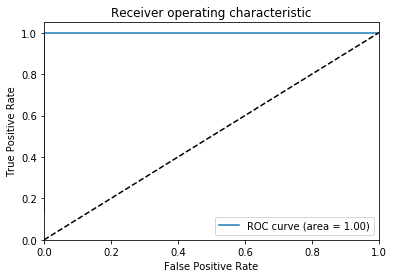

In [17]:
#https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/

results = predictionsAndLabelsDF.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Random Forest implementation + Visualization of results

Model Evaluation

In [20]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=2)

model = rf.fit(trainingDF)

predictions = model.transform(testDF)

results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

print(model)

The ROC score is (@numTrees=200):  1.0
RandomForestClassificationModel (uid=RandomForestClassifier_48a789b5f25a7098afd9) with 2 trees


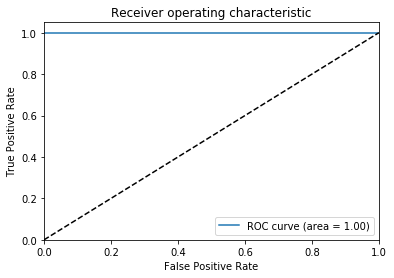

In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()